# Lens Modeling of DESIJ1501+5208 with Lenstronomy


Author: Mamun Hossain Nahid,  Anowar Shajib \
Acknowledgement: Tanjela, Nushrat, Imtiaz.

## Import of standard python libraries

In [ ]:
!pip install corner
!pip install emcee
!pip install lenstronomy


In [ ]:
import corner
import h5py
import joblib
import emcee
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

drive.mount("/content/drive")

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Mounted at /content/drive


In [ ]:
%matplotlib inline

## Load Imaging Data

In [ ]:
with h5py.File("/content/drive/MyDrive/5208 jan 17/DESIJ1501+5208_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

In [ ]:
with h5py.File("/content/drive/MyDrive/5208 jan 17/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

### Visualizing the Data

<ipython-input-6-357dad159cb2>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


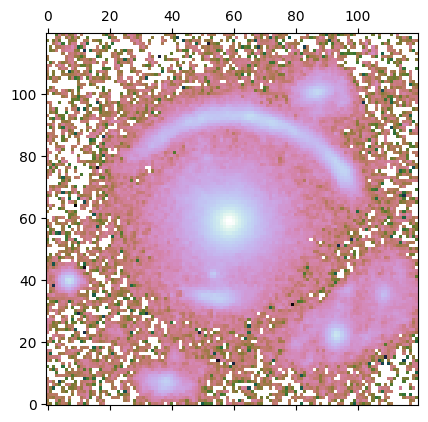

In [ ]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

## Creating Mask

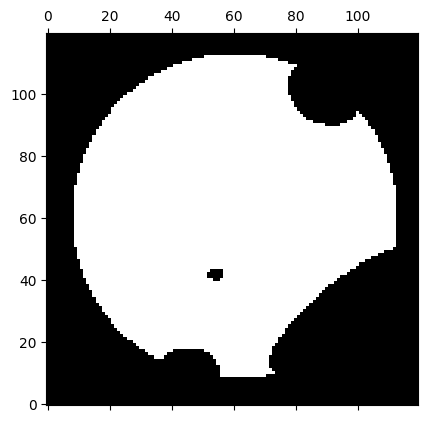

<ipython-input-7-d14db875bb19>:84: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
<ipython-input-7-d14db875bb19>:84: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


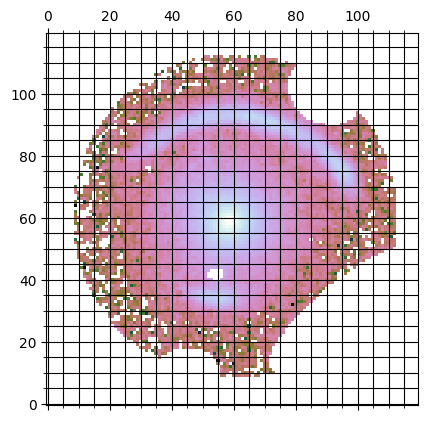

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.2  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 1 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 3.2,
    1.0,
    0.8,
    np.pi / 0.85,
)


# for the galaxy at 5 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.4,
    2.5,
    0.76,
    np.pi / 0.56,
)


# for the galaxy at 7 o clock
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.2,
    lens_center_dec - 4.0,
    0.8,
    0.6,
    0,
)

# for the galaxy at center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 1.5,
    0.2,
    0.15,
    0,
)

mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)
plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# applying the mask
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Lens Modeling with Lenstronomy

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass Model for the Lens Galaxy

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

EPL Parameters


In [ ]:
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": -0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


Shear Parameters

In [ ]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.1, "gamma2": 0.0, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

### Light Model for the Source Galaxy

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

Sersic Ellipse Parameters

In [ ]:
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.05,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.12,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


Shapelets Parameters

In [ ]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.04, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.06, "center_x": 10, "center_y": 10})

### Light Model for the Lens Galaxy

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

1st Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5767,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

2nd Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Combining Source and Lens Models

In [ ]:
joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

## Numerical Settings

In [ ]:
kwargs_likelihood = {"check_bounds": True,
                     "image_likelihood_mask_list": [mask],
                     "check_positive_flux": True}


kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

Combining All the Information to be Sent to Lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## PSO: Model Fitting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.8956704518239853 reduced X^2 of best position
-3377.1254386023365 log likelihood
7541 effective number of data points
[{'theta_E': 2.6425620638746845, 'gamma': 2.016663067766474, 'e1': 0.12869001213535267, 'e2': 0.06364292792199418, 'center_x': 0.03983332847610601, 'center_y': -0.20307280476278505}, {'gamma1': 0.16173513619640295, 'gamma2': 0.05205730951904264, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.11369161205592905, 'n_sersic': 1.0, 'e1': -0.09698376774666055, 'e2': 0.005610819563195426, 'center_x': -0.09364042474945093, 'center_y': 0.2759510122063946}, {'amp': 1, 'n_max': 8, 'beta': 0.053551894623778865, 'center_x': -0.09364042474945093, 'center_y': 0.2759510122063946}] source result
[{'amp': 1, 'R_sersic': 2.392138245064887, 'n_sersic': 1.0, 'e1': 0.011905631408100845, 'e2': 0.02027852188467458, 'center_x': 0.1428125025059829, 'cent

Save the Best Fit Parameters (PSO)





In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "/content/drive/MyDrive/5208 jan 17/DESIJ1501+5208_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

##PSO: Visualizing the fitted model

-0.8876660335706551 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8876660335706434


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-32-12d54f11901b>:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


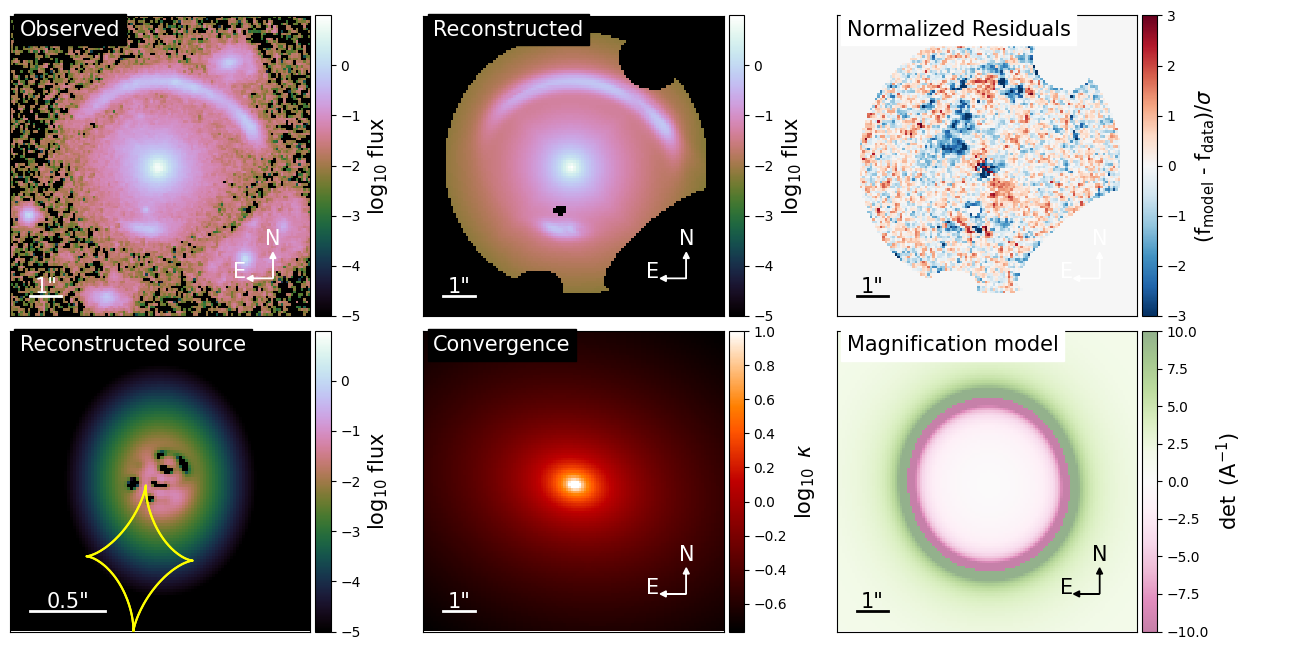

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


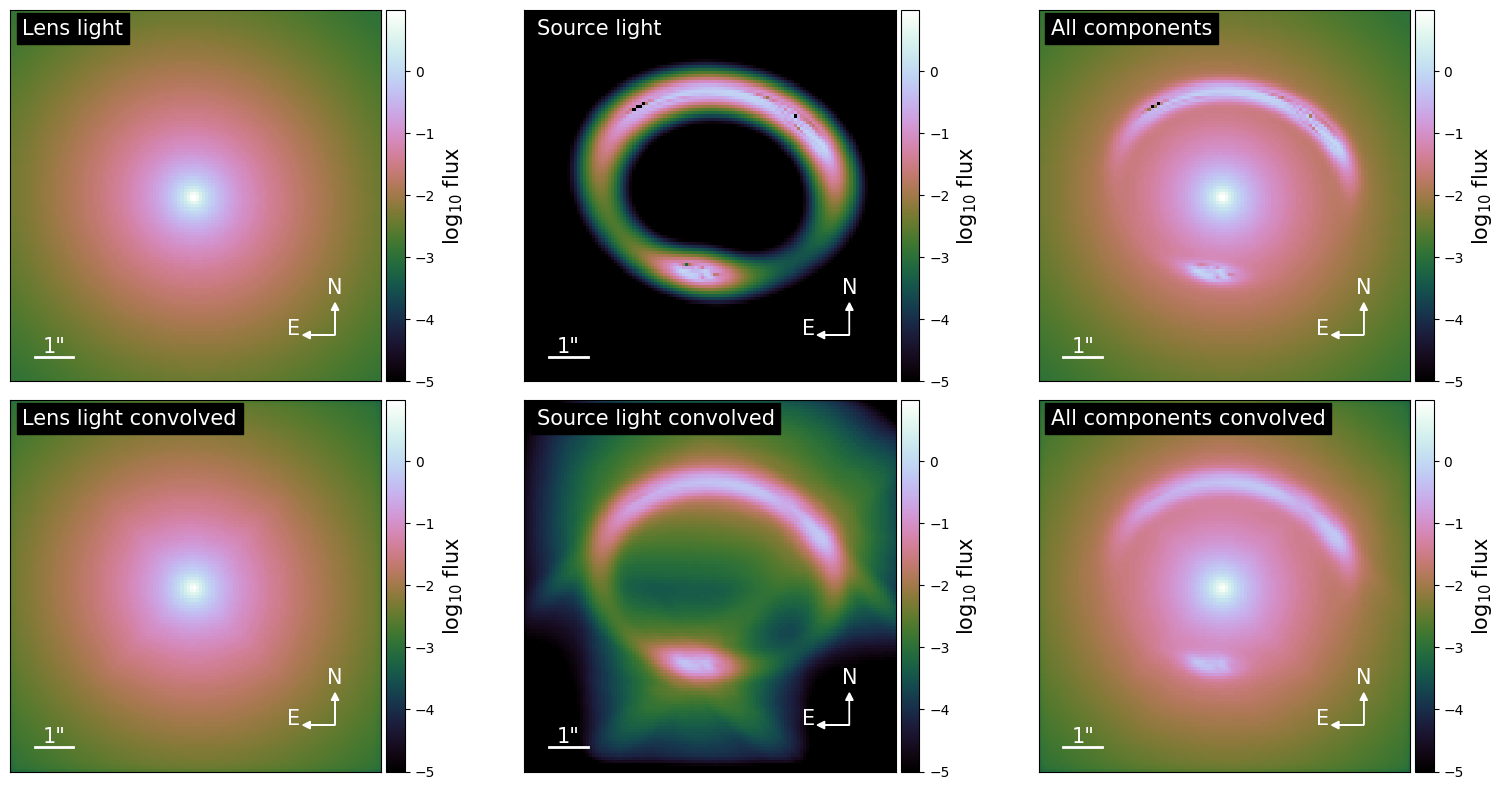

{'kwargs_lens': [{'theta_E': 2.6425620638746845, 'gamma': 2.016663067766474, 'e1': 0.12869001213535267, 'e2': 0.06364292792199418, 'center_x': 0.03983332847610601, 'center_y': -0.20307280476278505}, {'gamma1': 0.16173513619640295, 'gamma2': 0.05205730951904264, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 146.96392404951285, 'R_sersic': 0.11369161205592905, 'n_sersic': 1.0, 'e1': -0.09698376774666055, 'e2': 0.005610819563195426, 'center_x': -0.09364042474945093, 'center_y': 0.2759510122063946}, {'amp': array([-9.04943083e+02,  1.99657656e+01, -4.79548629e+01,  4.61250917e+01,
        1.12086429e+02, -8.26637439e+01,  1.23173312e+01, -4.09894265e+01,
        7.92034910e-01, -1.25979610e+02, -7.97969757e+01,  2.06224317e+01,
       -9.18807058e+00,  6.99543773e+01, -8.03398753e+01, -2.30482550e+01,
       -7.32576313e+01, -3.78102849e+01, -4.68250167e+00, -9.22281550e+01,
        2.97224753e+01, -5.63488427e+01,  1.53116972e+01,  2.70634192e+01,
        5.32281734e+01,  5.34180260e

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")


model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## MCMC: Model Fitting

In [ ]:
mcmc_backend = "/content/drive/MyDrive/5208 jan 17/mcmc_backend.h5"

n_walkers = 200
n_step = 5
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|██████████| 5/5 [05:49<00:00, 69.99s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 5
356.30256605148315 time taken for MCMC sampling


### Trace Plots

In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (392400, 20)



<ipython-input-24-b288d22036c9>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 1962, N_walkers: 200, N_params: 20
theta_E_lens0 2.6237 ± 0.0043
gamma_lens0 1.9429 ± 0.0324
e1_lens0 0.0976 ± 0.0104
e2_lens0 0.0064 ± 0.0069
center_x_lens0 0.0324 ± 0.0056
center_y_lens0 -0.2586 ± 0.0161
gamma1_lens1 0.1415 ± 0.0063
gamma2_lens1 0.0249 ± 0.0038
R_sersic_source_light0 0.1182 ± 0.0020
e1_source_light0 -0.0165 ± 0.0171
e2_source_light0 0.0174 ± 0.0129
center_x_source_light0 -0.0841 ± 0.0059
center_y_source_light0 0.2291 ± 0.0219
beta_source_light1 0.0551 ± 0.0026
R_sersic_lens_light0 2.4828 ± 0.1639
e1_lens_light0 0.0144 ± 0.0027
e2_lens_light0 0.0194 ± 0.0028
center_x_lens_light0 0.1434 ± 0.0010
center_y_lens_light0 -0.1369 ± 0.0006
R_sersic_lens_light1 0.5981 ± 0.0112


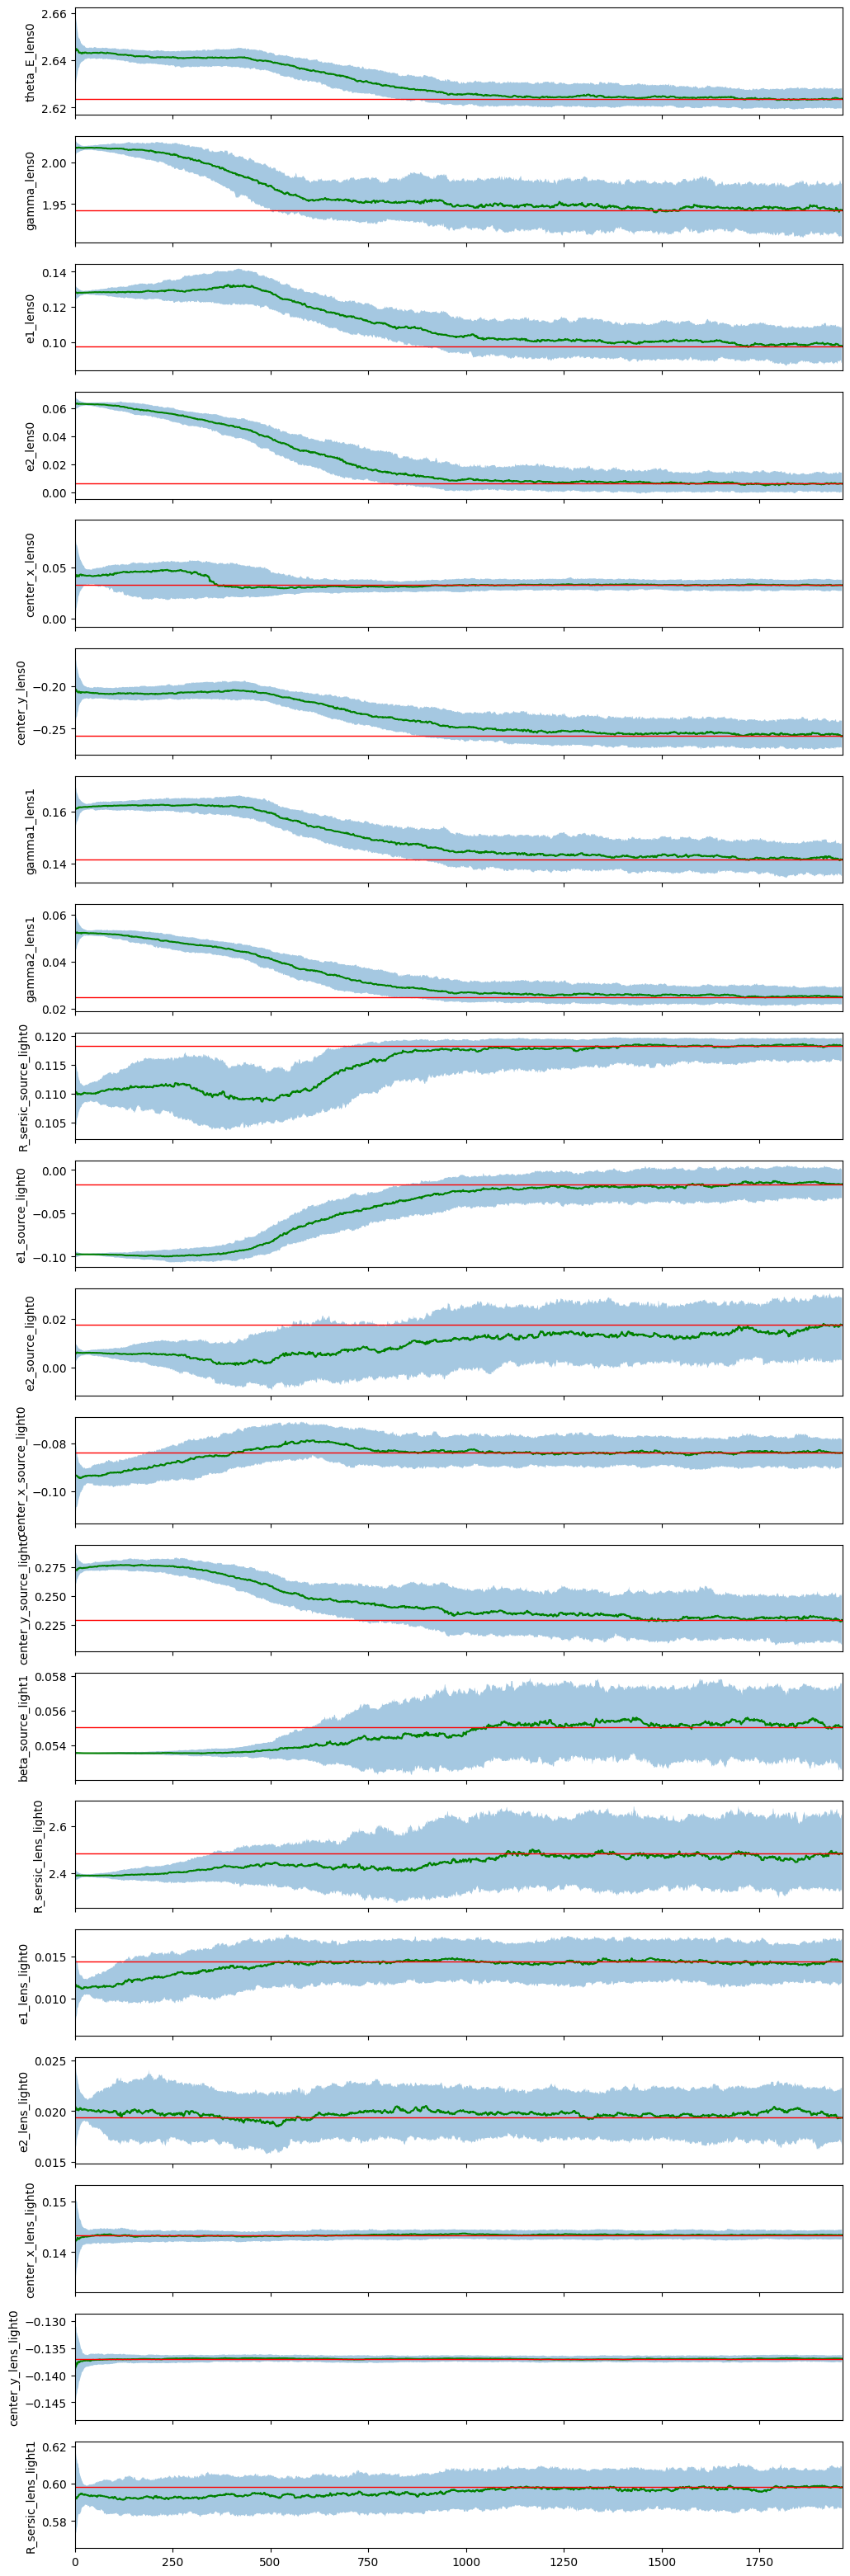

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

### Corner Plots

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1000
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

Output hidden; open in https://colab.research.google.com to view.

## MCMC: Visualizing the Fitted Model

-0.8780214882851413 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8780214882851138


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-26-628449185b14>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


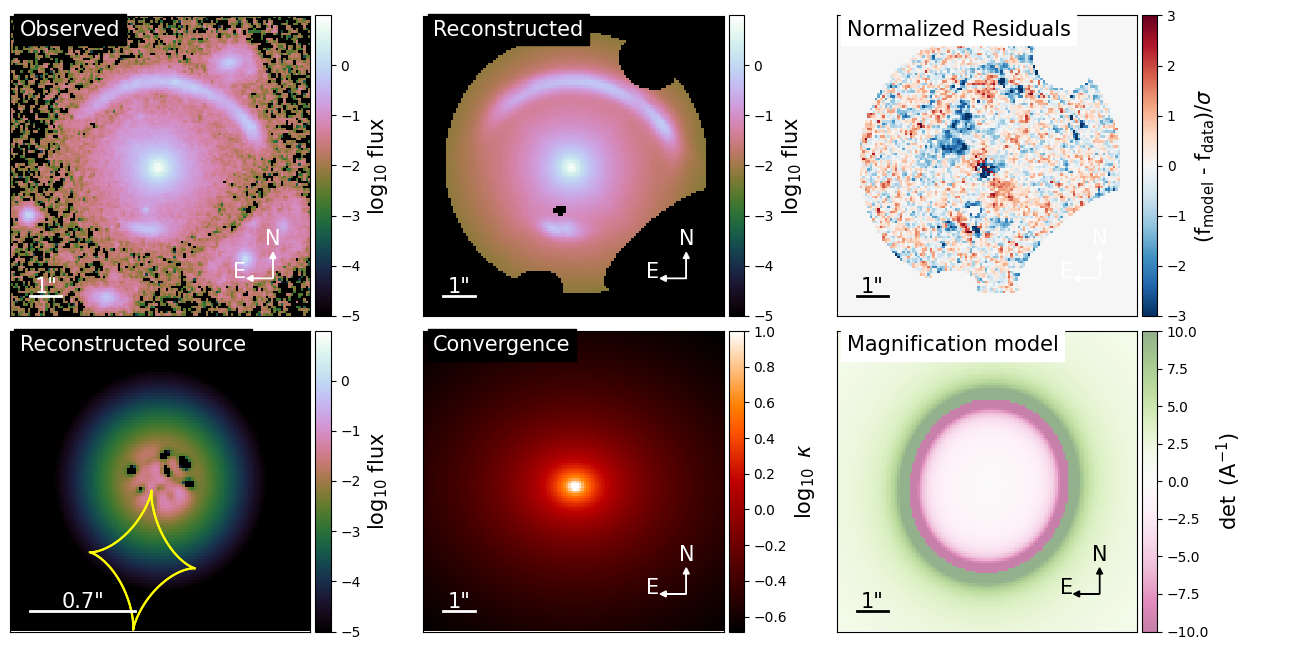

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


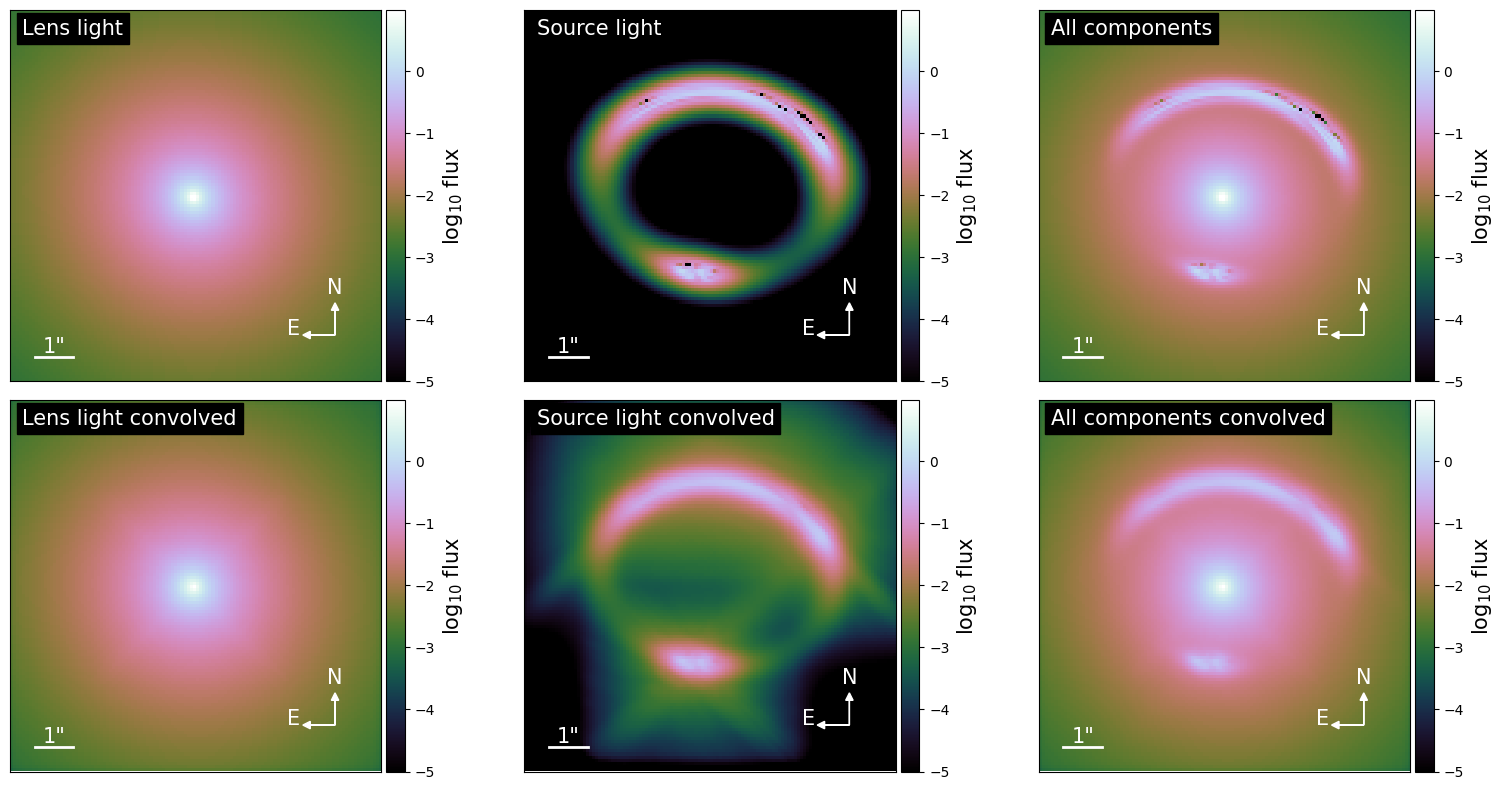

{'kwargs_lens': [{'theta_E': 2.6243386511179003, 'gamma': 1.9512872134249037, 'e1': 0.10216463042425473, 'e2': 0.006239684521006712, 'center_x': 0.030535541594801565, 'center_y': -0.2552910161256611}, {'gamma1': 0.14399903785481913, 'gamma2': 0.025714610326087652, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 122.35124103857181, 'R_sersic': 0.11920344517763987, 'n_sersic': 1.0, 'e1': -0.02398697044118705, 'e2': 0.0041814740117194354, 'center_x': -0.0862602525740498, 'center_y': 0.23294979117775658}, {'amp': array([-724.80874265,   63.9688401 ,  -33.75657485,  -36.02249526,
         98.80328447,  -57.00963376,  -38.25568103,  -69.60567554,
        -18.7360866 ,  -59.11215285,  -74.25077498,   23.9897538 ,
          3.67161391,   45.26304241,  -23.43872547,   16.90462337,
        -33.33899607,  -70.03633025,  -25.79803025,  -46.54852542,
        -74.64079183,  -29.68021721,   67.47957373,   38.19218636,
          8.20924015,    4.86844866,   54.01818231,   -4.23541895,
         20.2

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy

In [ ]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {},\nmass_phi: {},\nlight_phi: {}, ".format(
        mass_q,
        light_q,
        mass_phi,
        light_phi,
    )
)

mass_q: 0.8142975772611012,
light_q: 0.9514884847941206,
mass_phi: 0.030499515985332768,
light_phi: 0.4579011735493019, 


Save the Best Fit Parameters (MCMC)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 1862
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]
output_path = "/content/drive/MyDrive/5208 jan 17/DESIJ1501+5208_mcmc_output.joblib"


with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)


Number of evaluations in the MCMC process: 392400
392400
Shape of shortened_samples_mcmc: (1000, 20)


In [ ]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [2.6236730835762194, 0.00433098622960415, 0.004045711730063406], 'gamma_lens0': [1.944406806098427, 0.02979156939151828, 0.030237525405891752], 'center_x_lens0': [0.03255858309794374, 0.005513761395191358, 0.005350430028006829], 'center_y_lens0': [-0.2565349455032595, 0.016848807849943442, 0.01720788786226879], 'center_x_lens_light0': [0.14340224509719995, 0.0009292862815809266, 0.0008700656680023511], 'center_y_lens_light0': [-0.13694149527066024, 0.000632196028606119, 0.0005960096987570329]}


In [ ]:
import corner
import h5py
import joblib
import emcee
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import yaml
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Util import param_util
%matplotlib inline

In [ ]:
# Mapping of old parameter names to new parameter names
param_name_mapping ={
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
}

# Rename parameters in the parameter_values dictionary
parameter_values = {param_name_mapping.get(k, k): v for k, v in parameter_values.items()}


for key, value in parameter_values.items():
    print(f"{key}: {value}")


theta_E: [2.6236730835762194, 0.00433098622960415, 0.004045711730063406]
gamma: [1.944406806098427, 0.02979156939151828, 0.030237525405891752]
center_x_mass: [0.03255858309794374, 0.005513761395191358, 0.005350430028006829]
center_y_mass: [-0.2565349455032595, 0.016848807849943442, 0.01720788786226879]
center_x_light: [0.14340224509719995, 0.0009292862815809266, 0.0008700656680023511]
center_y_light: [-0.13694149527066024, 0.000632196028606119, 0.0005960096987570329]


In [ ]:
# Initial parameters list
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

# converted parameters list

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]

n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E': [2.6236730835762194, 0.00433098622960415, 0.004045711730063406], 'gamma': [1.944406806098427, 0.02979156939151828, 0.030237525405891752], 'center_x_mass': [0.03255858309794374, 0.005513761395191358, 0.005350430028006829], 'center_y_mass': [-0.2565349455032595, 0.016848807849943442, 0.01720788786226879], 'center_x_light': [0.14340224509719995, 0.0009292862815809266, 0.0008700656680023511], 'center_y_light': [-0.13694149527066024, 0.000632196028606119, 0.0005960096987570329], 'phi_mass': [0.032502668617175615, 0.03313061643556263, 0.029133736896994313], 'q_mass': [0.8196351999986494, 0.018012144718435263, 0.01735241985515168], 'phi_shear': [0.08840104677430449, 0.010808453529417991, 0.011117249803834384], 'gamma_shear': [0.14410721778932056, 0.007343952012220295, 0.006612490635372448], 'phi_light': [0.46855356594701875, 0.052849123733838155, 0.050310799219875635], 'q_light': [0.9524829662780083, 0.004765150943324192, 0.005578873926002426]}


In [ ]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius

for key, value in parameter_values.items():
    print(f"{key}: {value}")


Half-light radius: 0.6922716809172538
theta_E: [2.6236730835762194, 0.00433098622960415, 0.004045711730063406]
gamma: [1.944406806098427, 0.02979156939151828, 0.030237525405891752]
center_x_mass: [0.03255858309794374, 0.005513761395191358, 0.005350430028006829]
center_y_mass: [-0.2565349455032595, 0.016848807849943442, 0.01720788786226879]
center_x_light: [0.14340224509719995, 0.0009292862815809266, 0.0008700656680023511]
center_y_light: [-0.13694149527066024, 0.000632196028606119, 0.0005960096987570329]
phi_mass: [0.032502668617175615, 0.03313061643556263, 0.029133736896994313]
q_mass: [0.8196351999986494, 0.018012144718435263, 0.01735241985515168]
phi_shear: [0.08840104677430449, 0.010808453529417991, 0.011117249803834384]
gamma_shear: [0.14410721778932056, 0.007343952012220295, 0.006612490635372448]
phi_light: [0.46855356594701875, 0.052849123733838155, 0.050310799219875635]
q_light: [0.9524829662780083, 0.004765150943324192, 0.005578873926002426]
R_eff_light: 0.6922716809172538
